In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf

# Dane

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

## Treningowe

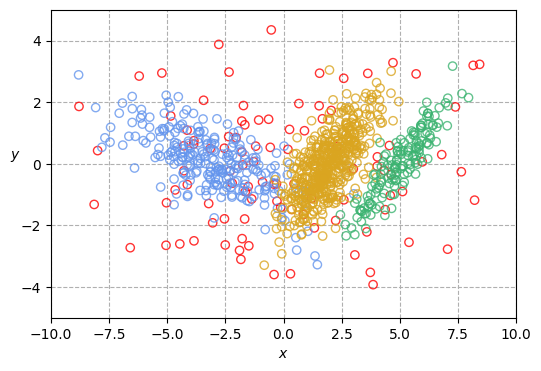

In [3]:
np.random.seed(1)

# Data
n_experiments = 2  # 100
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

In [4]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

\newpage

# Ujęcie bezwarunkowe

Do detekcji elementów nietypowych stosowana jest metoda podstawień rzędu 2.

## Pojedynczy eksperyment (r=0.1)

Wskaźnik jakości (PI_kf): 0.517670


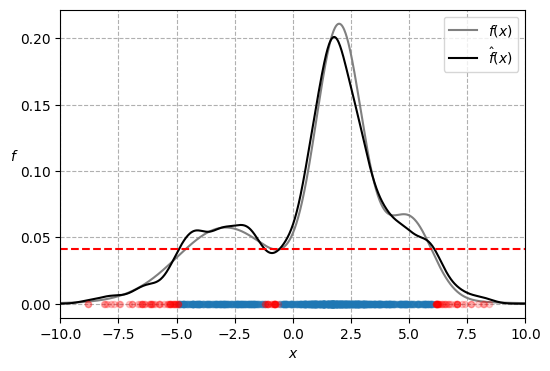

In [6]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0], r=0.1)
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])

metric = pi_kf(x_train[0], labels_pred)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")


true_dist1 = m_train1 / m_train * norm.pdf(x_grid, loc=-3, scale=2)
true_dist2 = m_train2 / m_train * norm.pdf(x_grid, loc=2, scale=1)
true_dist3 = m_train3 / m_train * norm.pdf(x_grid, loc=5, scale=1)
true_dist4 = m_train4 / m_train * norm.pdf(x_grid, loc=0, scale=4)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

\newpage

### Dopasowanie $h$ oraz $r$ na siatce

In [7]:
h_mul_grid = (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {h_mul_grid}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [8]:
best_metric = np.inf
for h_mul in h_mul_grid:
    for r in r_grid:
        kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * h_mul, r=r)
        labels_pred = kde_outlier_detector.predict(x_train[0])
        metric = pi_kf(x_train[0], labels_pred, bandwidth=bandwidth_x[0] * h_mul)
        if metric < best_metric:
            best_h_mul = h_mul
            best_r = r
            best_metric = metric

print(f"Najlepszy mnożnik h: {best_h_mul:.2f} oraz r {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h: 1.00 oraz r 0.04
Przy wskaźniku jakości: 0.327785


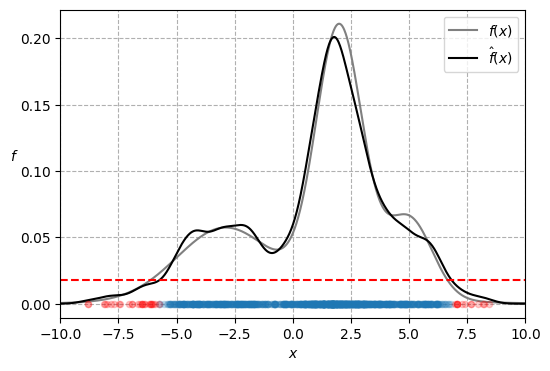

In [10]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train[0], bandwidth=bandwidth_x[0] * best_h_mul, r=best_r)
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train[0])


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x)$")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[0, labels_pred==0], x_train[0, labels_pred==0]*0, s=20, alpha=0.2, zorder=2)
plt.scatter(x_train[0, labels_pred==1], x_train[0, labels_pred==1]*0, c="red", s=20, alpha=0.2, zorder=2)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

\newpage

## Wielokrotne eksperymenty (r=0.1)

In [11]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    kde_outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e], r=0.1)
    labels_pred = kde_outlier_detector.predict(x_train[e])
    metrics[e] = pi_kf(x_train[e], labels_pred)

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 2 eksperymentów (pi_kf): 0.525598 +- 0.007928


### Dopasowanie $h$ oraz $r$ na siatce

In [12]:
h_mul_grid = (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {h_mul_grid}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [13]:
best_metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train[e], bandwidth=bandwidth_x[e] * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train[e])
            metric = pi_kf(x_train[e], labels_pred, bandwidth=bandwidth_x[e] * h_mul)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric
    best_metrics[e] = best_metric

    
print(f"Wskaźnik jakości dla {n_experiments} eksperymentów (pi_kf): {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")

Wskaźnik jakości dla 2 eksperymentów (pi_kf): 0.298837 +- 0.028949


\newpage

# Ujęcie warunkowe

## Pojedynczy eksperyment (r=0.1, $y^* = y_i$)

In [43]:
labels_pred = np.empty(m_train, dtype=np.int32)
scores = np.empty(m_train)

for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0],
                                                        r=0.1)
    labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    
    scores[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])

In [44]:
inliers = labels_pred == 0
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()

scores_out = scores[outliers]
scores_in = np.sort(scores[inliers])[:n_outliers]

metric = np.sum(scores_out) / np.sum(scores_in)
print(f"Wskaźnik jakości (PI_kf): {metric:.6f}")

Wskaźnik jakości (PI_kf): 0.585904


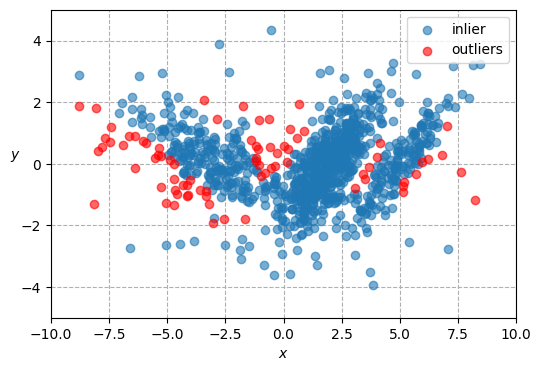

In [45]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

/newpage

### Dopasowanie $h$ oraz $r$ na siatce

In [46]:
h_mul_grid = (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
r_grid = (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)

print(f"Siatka dla mnożników h: {h_mul_grid}")
print(f"Siatka dla r: {r_grid}")

Siatka dla mnożników h: (1.0, 0.9, 1.1, 0.8, 1.2, 0.7, 1.3, 0.6, 1.4, 0.5, 1.5)
Siatka dla r: (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2)


In [47]:
best_metric = np.inf
for h_mul in h_mul_grid:
    for r in r_grid:

        labels_pred = np.empty(m_train, dtype=np.int32)
        scores = np.empty(m_train)

        for i in range(m_train):
            ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                                bandwidth_x=bandwidth_x[0] * h_mul,
                                                                bandwidth_y=bandwidth_y[0] * h_mul,
                                                                r=r)
            labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])

            scores[i] = ckde_outlier_detector.ckde.pdf(x_train[0, [i]])
        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        scores_out = scores[outliers]
        scores_in = np.sort(scores[inliers])[:n_outliers]
        metric = np.sum(scores_out) / np.sum(scores_in)

        if metric < best_metric:
            best_h_mul = h_mul
            best_r = r
            best_metric = metric

print(f"Najlepszy mnożnik h: {best_h_mul:.2f} oraz r {best_r:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h: 1.50 oraz r 0.02
Przy wskaźniku jakości: 0.445738


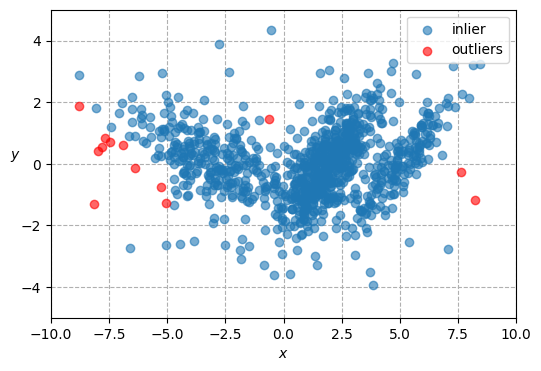

In [48]:
labels_pred = np.empty(m_train, dtype=np.int32)

for i in range(m_train):
    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_train[0, i],
                                                        bandwidth_x=bandwidth_x[0] * best_h_mul,
                                                        bandwidth_y=bandwidth_y[0] * best_h_mul,
                                                        r=best_r)
    labels_pred[i] = ckde_outlier_detector.predict(x_train[0, [i]])
    

##
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

\newpage

## $y^*=0$

In [12]:
# y_star_neg = np.array([-2.0] * n_y)
y_star_0 = np.array([0.0] * n_y)
# y_star_pos = np.array([2.0] * n_y)

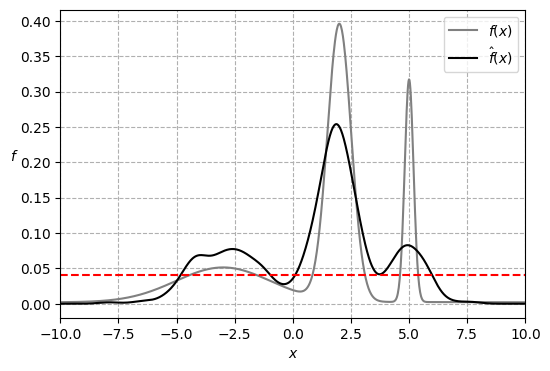

In [13]:
ckde_outlier_detector_0 = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star_0,
                                                      bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores_0 = ckde_outlier_detector_0.ckde.pdf(x_grid)

true_dist1 = m_train1/m_train * norm.pdf(x_grid, loc=-3, scale=2.04)
true_dist2 = m_train2/m_train * norm.pdf(x_grid, loc=2, scale=0.51)
true_dist3 = m_train3/m_train * norm.pdf(x_grid, loc=5, scale=0.19)
true_dist4 = m_train4/m_train * norm.pdf(x_grid, loc=0, scale=16)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x)$")
plt.plot(x_grid, scores_0, c="k", label="$\hat{f}(x)$")
plt.hlines(best_kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

In [14]:
labels_pred = ckde_outlier_detector_0.predict(x_train[0])

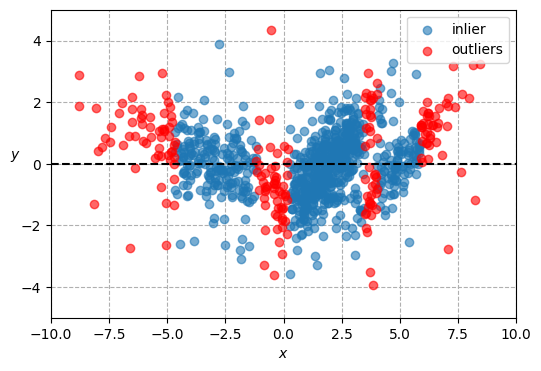

In [15]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[0, labels_pred==0], y_train[0, labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[0, labels_pred==1], y_train[0, labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")
plt.hlines(y_star_0[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()